In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalisation(k_Ca):
    min_Ca = np.min(k_Ca)
    max_Ca = np.max(k_Ca)
    return (k_Ca - min_Ca) / (max_Ca - min_Ca)

In [3]:
def lirinzel_ns(v2, a2, IP3, d5, k3):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, 0.1)
    dt = 0.1
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))
        
        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    Ca_norm = normalisation(Ca)

    return Ca_norm

In [63]:
np.random.seed(2)

size1 = 3
v2 = np.random.uniform(0, 0.3, size1)
a2 = np.random.uniform(0, 0.5, size1)
IP3 = np.random.uniform(0, 1.5, size1)
d5 = np.random.uniform(0, 0.2, size1)
k3 = np.random.uniform(0, 0.3, size1)

In [64]:
Ca_matrix = []
v2_matrix = []
a2_matrix = []
IP3_matrix = []
d5_matrix = []
k3_matrix = []

for i in range(size1):
    for j in range(size1):
        for k in range(size1):
            for l in range(size1):
                for n in range(size1):

                    v2_i = v2[i]
                    a2_j = a2[j]
                    IP3_k = IP3[k]
                    d5_l = d5[l]
                    k3_n = k3[n]

                    Ca = lirinzel_ns(v2_i, a2_j, IP3_k, d5_l, k3_n)
                    Ca_matrix.append(Ca)

                    v2_matrix.append(v2_i)
                    a2_matrix.append(a2_j)
                    IP3_matrix.append(IP3_k)
                    d5_matrix.append(d5_l)
                    k3_matrix.append(k3_n)

Ca_matrix = np.array(Ca_matrix)

In [34]:
Ca_matrix.shape

(243, 3000)

In [92]:
from scipy.stats import weibull_min, lognorm, gamma, expon, norm

def weibull_pdf(x, data):
    c, loc, scale = weibull_min.fit(data, floc=0)
    return weibull_min.pdf(x, c, loc=loc, scale=scale)

def lognormal_pdf(x, data):
    # Keep only positive values
    data = data[data > 0]
    if len(data) == 0:
        return np.zeros_like(x)  # No valid data to fit
    shape, loc, scale = lognorm.fit(data, floc=0)
    return lognorm.pdf(x, shape, loc=loc, scale=scale)

def gamma_pdf(x, data):
    data = data[data > 0]
    if len(data) == 0:
        return np.zeros_like(x)
    a, loc, scale = gamma.fit(data, floc=0)
    return gamma.pdf(x, a, loc=loc, scale=scale)

def exponential_pdf(x, data):
    loc, scale = expon.fit(data, floc=0)
    return expon.pdf(x, loc=loc, scale=scale)

def normal_pdf(x, data):
    mu, std = norm.fit(data)
    return norm.pdf(x, mu, std)

def pdf_clip(pdf):
    threshold = np.percentile(pdf, 95)
    pdf_clipped = np.clip(pdf, 0, threshold)
    return pdf_clipped

In [100]:
def plot_dist(n): 
    t = np.arange(0, 300, 0.1)
    for i in range(n):
        j = np.random.randint(0, 243)
        plt.figure(figsize=(14, 4))
        plt.subplot(121)
        plt.plot(t, Ca_matrix[j])
    
        data = Ca_matrix[j]
        x = np.linspace(min(data), max(data), len(data))
        pdf_weibul = pdf_clip(weibull_pdf(x, data))
        pdf_lognorm = pdf_clip(lognormal_pdf(x, data))
        pdf_gamma = pdf_clip(gamma_pdf(x, data))
        pdf_exp = pdf_clip(exponential_pdf(x, data))
        pdf_norm = pdf_clip(normal_pdf(x, data))
    
        plt.subplot(122)
        plt.hist(data, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Data Histogram')

        # Plot fitted PDF
        plt.plot(x, pdf_weibul, lw=2, label='Fitted Weibull PDF', color='red')
        plt.plot(x, pdf_lognorm, lw=2, label='Fitted Lognormal PDF', color='blue')
        plt.plot(x, pdf_gamma, lw=2, label='Fitted Gamma PDF', color='black')
        plt.plot(x, pdf_exp, lw=2, label='Fitted Exponential PDF', color='green')
        plt.plot(x, pdf_norm, lw=2, label='Fitted Normal PDF', color='orange')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

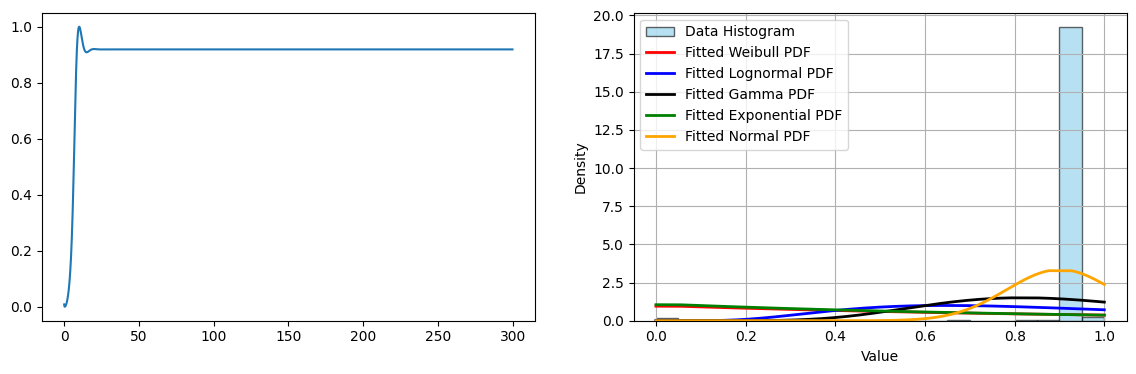

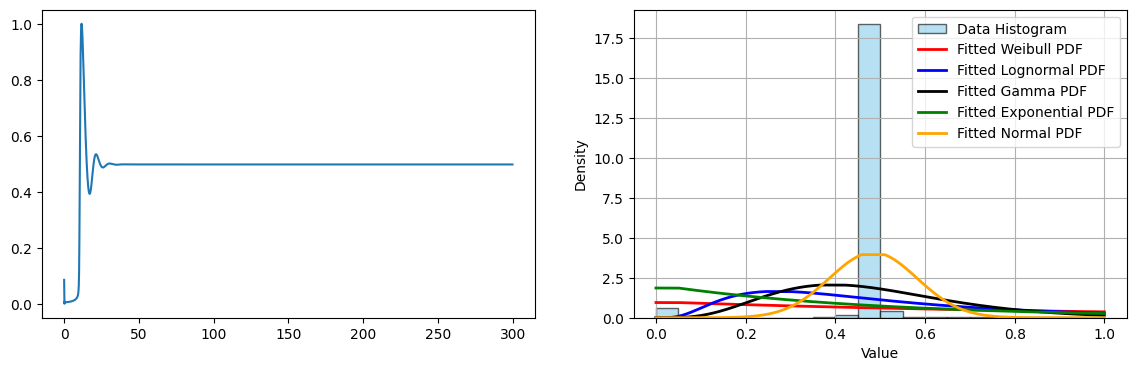

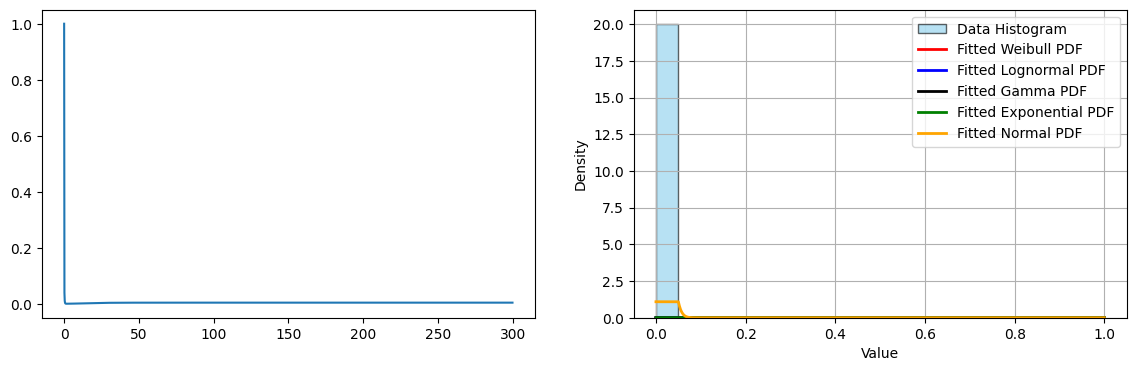

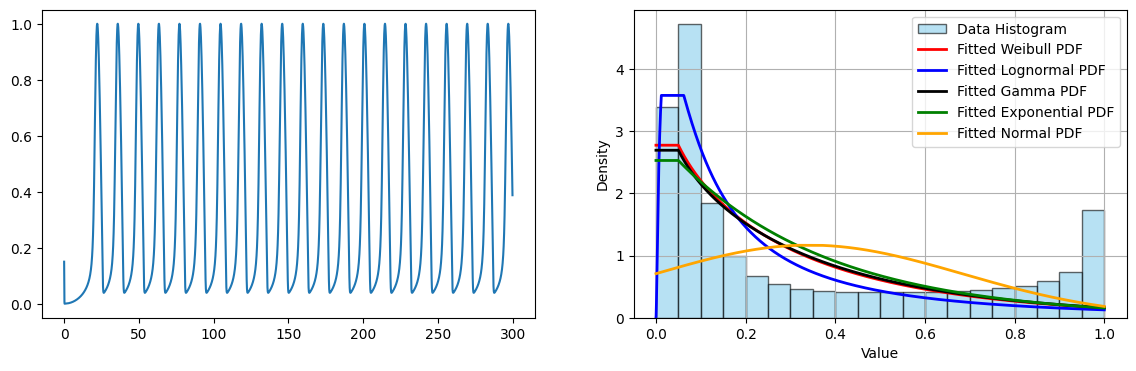

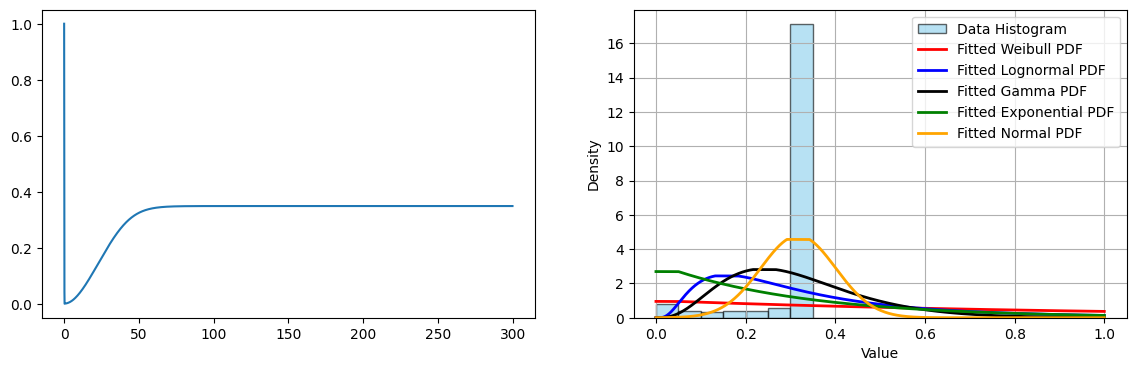

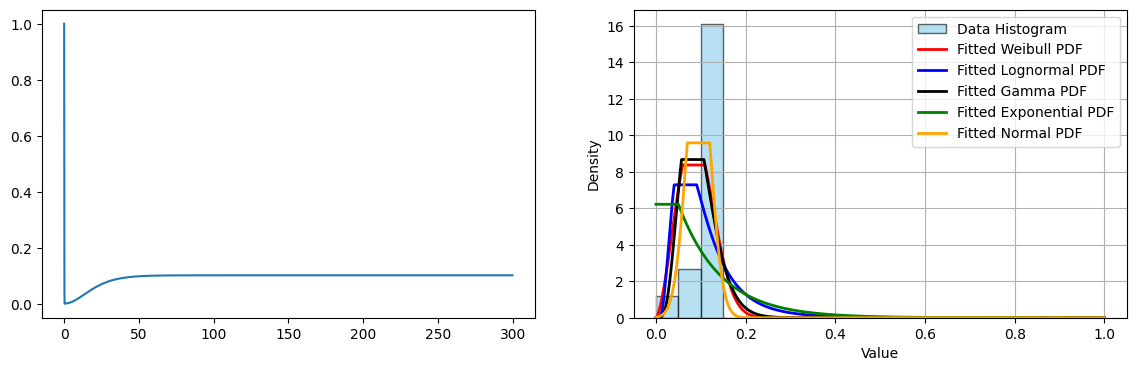

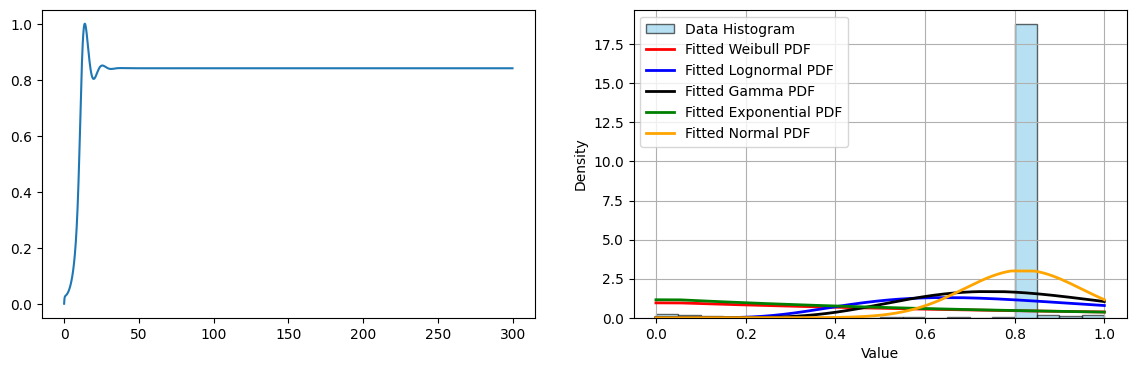

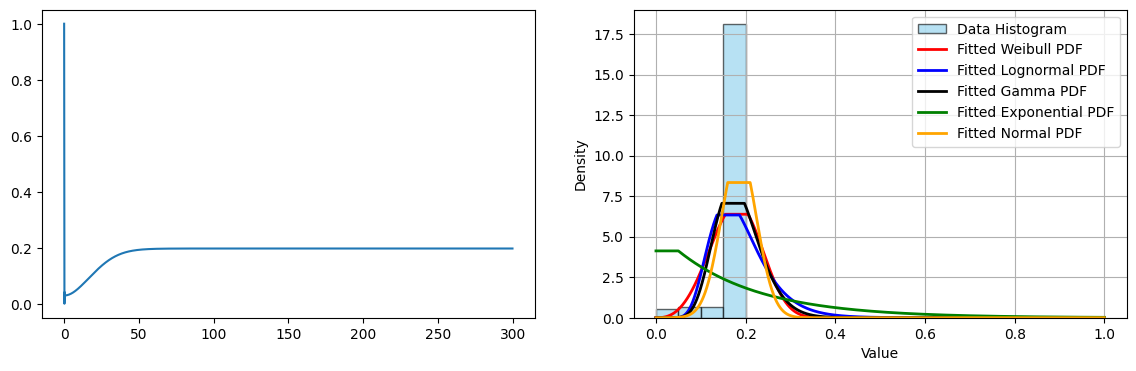

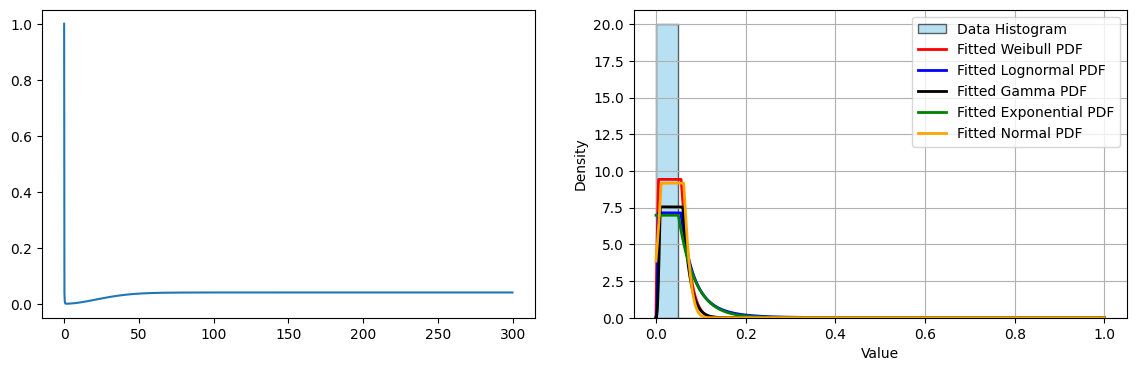

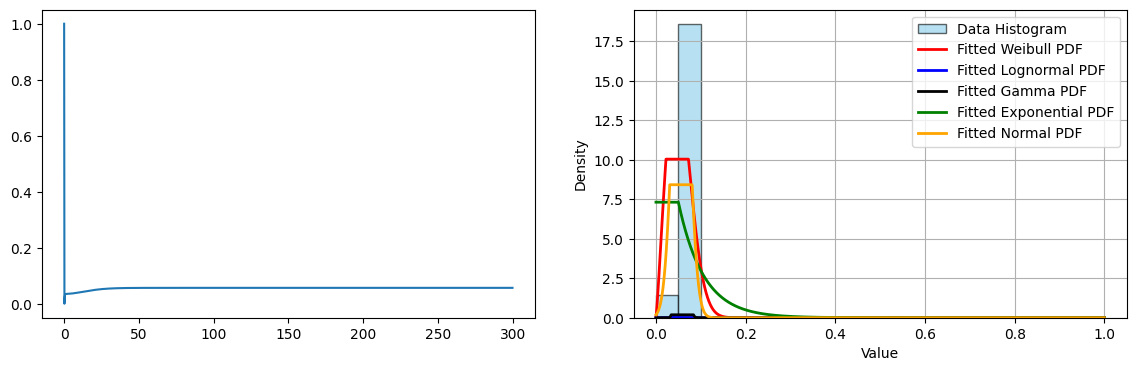

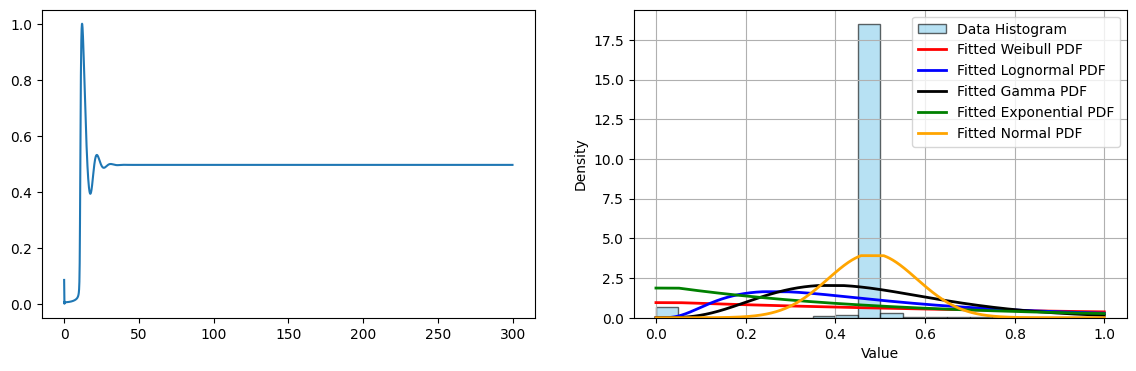

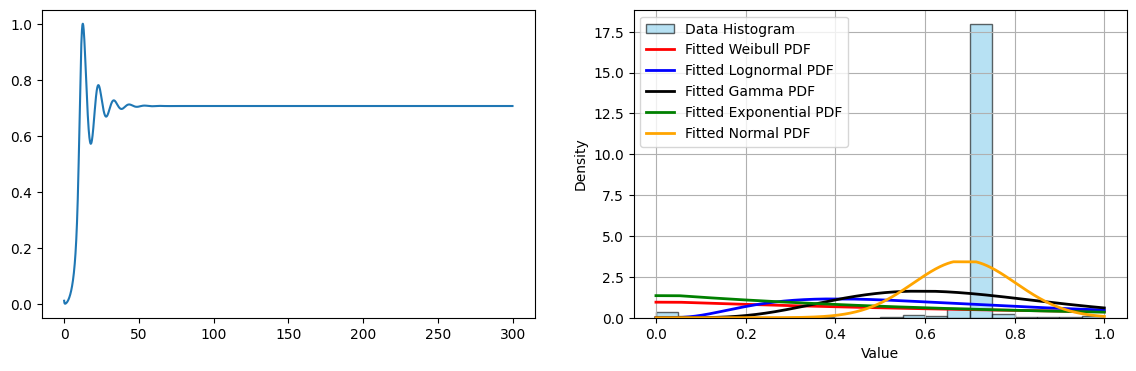

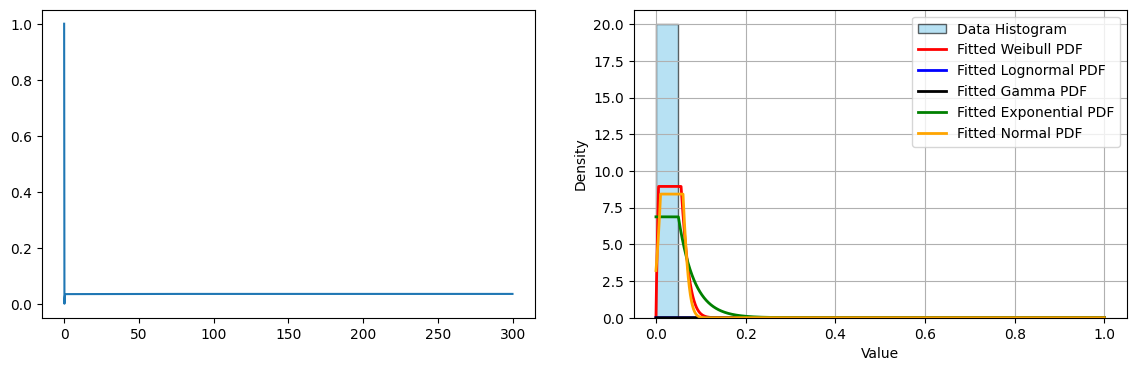

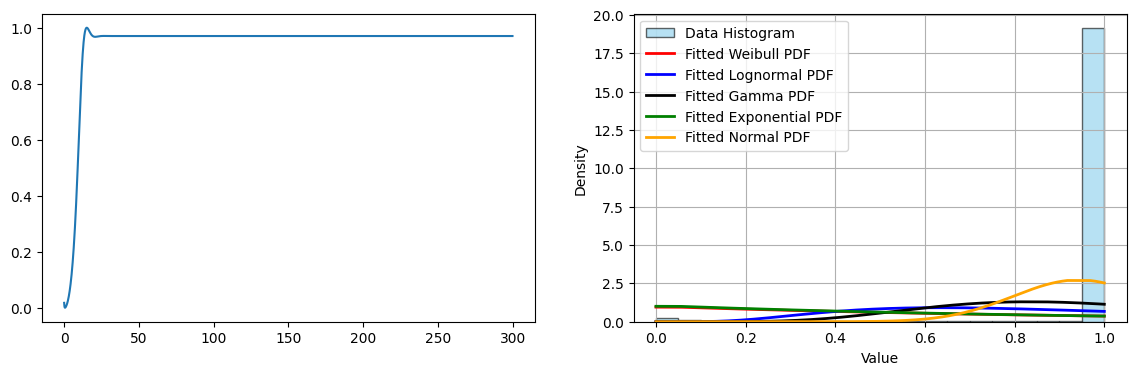

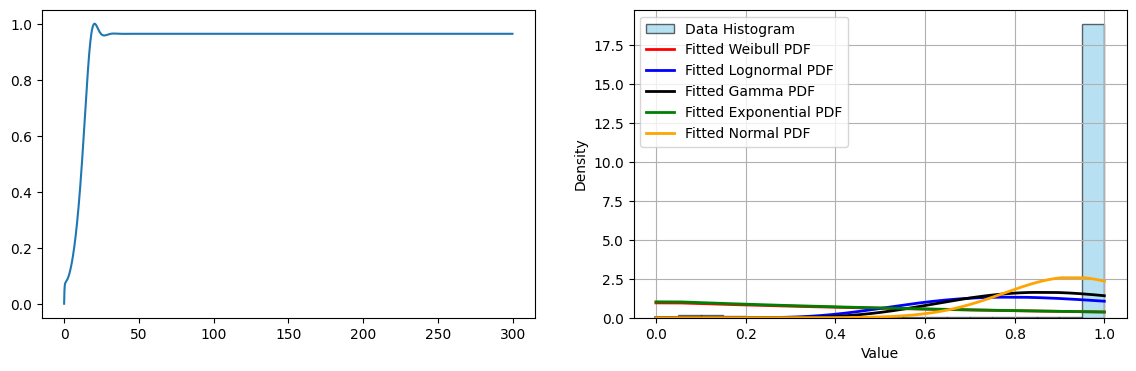

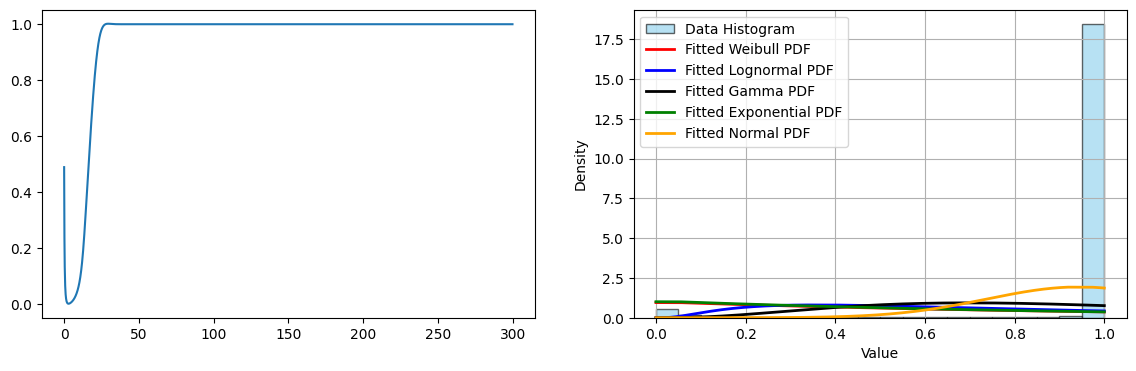

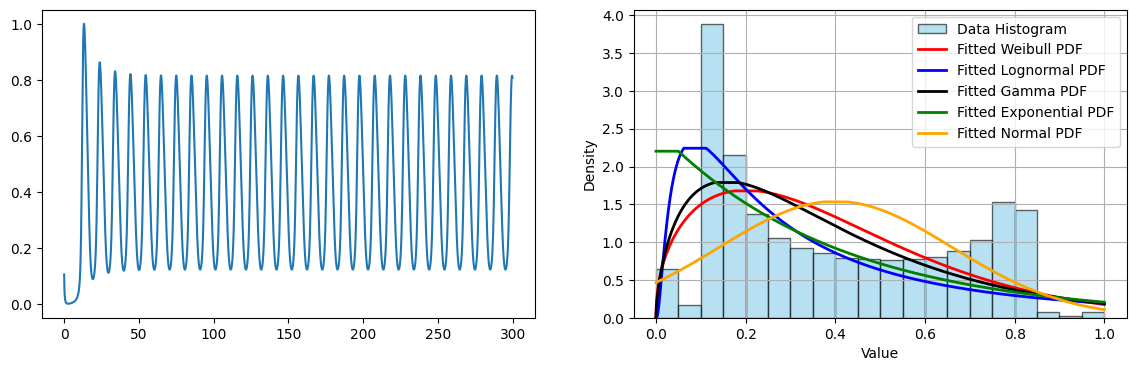

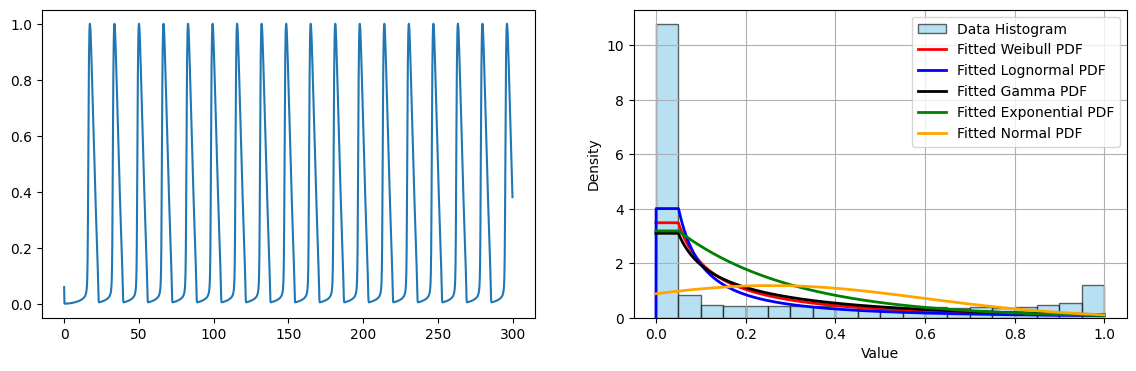

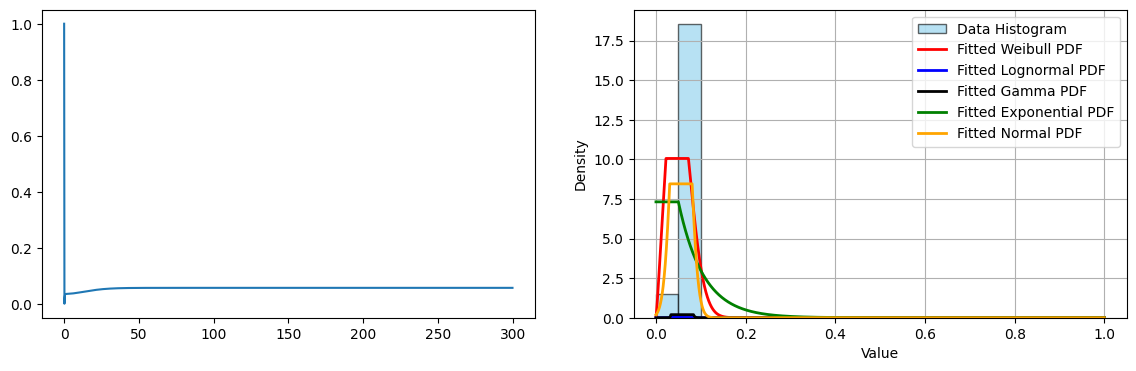

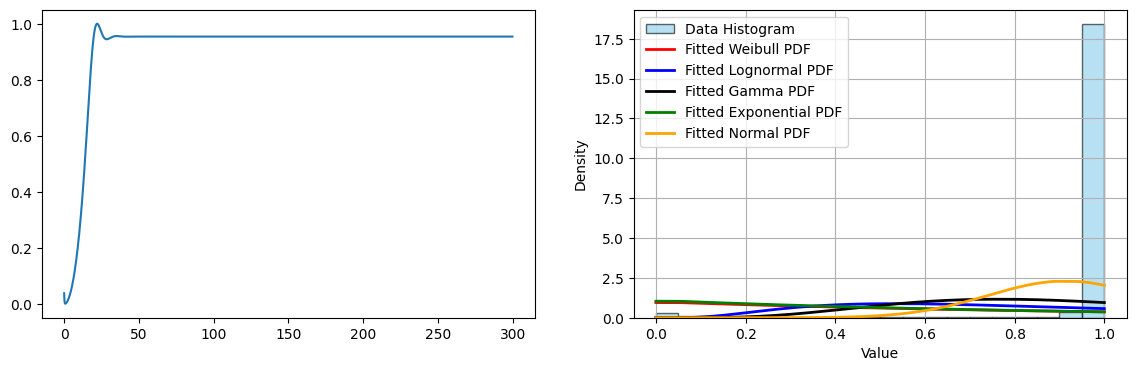

In [102]:
plot_dist(20)